Total points for this HW: 10

Make sure that you run all your codes and that all results are printed.

Please note: Copying and pasting other people's work is absolutely prohibited. Any such cases will be reported to CUSP's education team and severely punished. Discussion is encouraged, and feel free to exchange ideas with your classmates, but please write your own code and do your own work.

### Question 1 (40%)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y).

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10%)

2) The log marginal likelihood of the training data. (5%)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10%)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5%)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10%)


In [26]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

In [28]:
Data1['log_count'] = np.log(Data1['AvgDailyTrafficCount'])
Data1['log_count_centered'] = Data1['log_count'] - np.mean(Data1['log_count'])

In [29]:
kernel = ConstantKernel() * RBF(length_scale=[1, 1], length_scale_bounds=(1e-2, 1e2)) + WhiteKernel(noise_level=1)
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
X = Data1[['Longitude', 'Latitude']].values
y = Data1['log_count_centered'].values
gp.fit(X, y)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [30]:
optimized_kernel = gp.kernel_
log_marginal_likelihood = gp.log_marginal_likelihood_value_

In [31]:
print("Optimized Kernel:", optimized_kernel)
print("Log Marginal Likelihood:", log_marginal_likelihood)

Optimized Kernel: 0.658**2 * RBF(length_scale=[0.0326, 0.0395]) + WhiteKernel(noise_level=0.568)
Log Marginal Likelihood: -1365.2762643118933


In [32]:
x = np.linspace(Data1['Longitude'].min(), Data1['Longitude'].max(), 100)
y = np.linspace(Data1['Latitude'].min(), Data1['Latitude'].max(), 100)
X, Y = np.meshgrid(x, y)
X_flat = np.vstack((X.ravel(), Y.ravel())).T

In [33]:
y_pred, std_dev = gp.predict(X_flat, return_std=True)
Z = y_pred.reshape(X.shape)

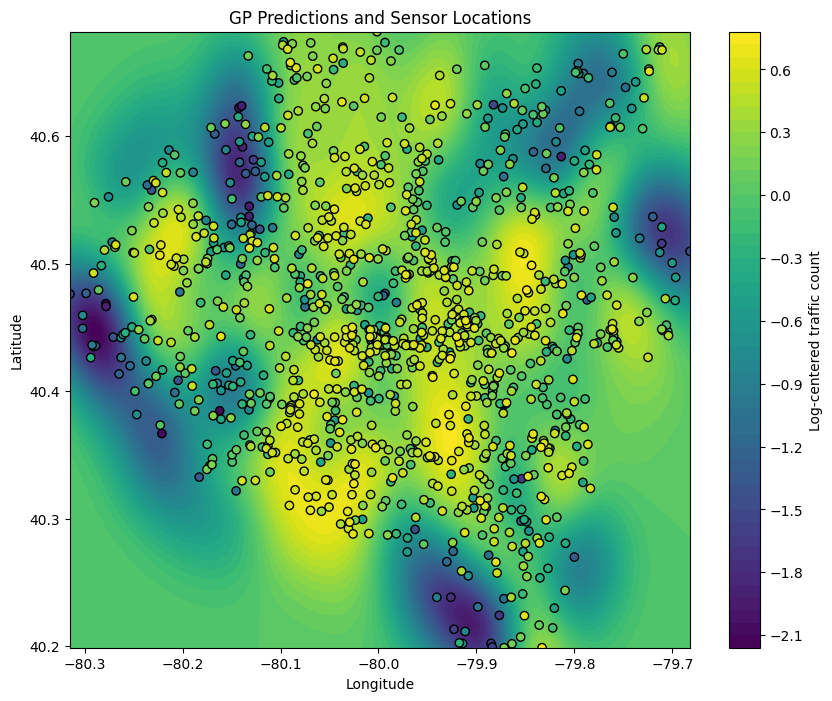

In [34]:
plt.figure(figsize=(10, 8))
contour = plt.contourf(X, Y, Z, levels=50, cmap='viridis')
cbar = plt.colorbar(contour)
cbar.set_label('Log-centered traffic count')
plt.scatter(Data1['Longitude'], Data1['Latitude'], c=Data1['log_count_centered'], cmap='viridis', edgecolor='k')
plt.title('GP Predictions and Sensor Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [35]:
predictions, std_dev = gp.predict(Data1[['Longitude', 'Latitude']].values, return_std=True)
Data1['deviation'] = (Data1['log_count_centered'] - predictions) / std_dev

extreme_deviation_percentage = ((np.abs(Data1['deviation']) > 2).sum() / len(Data1)) * 100

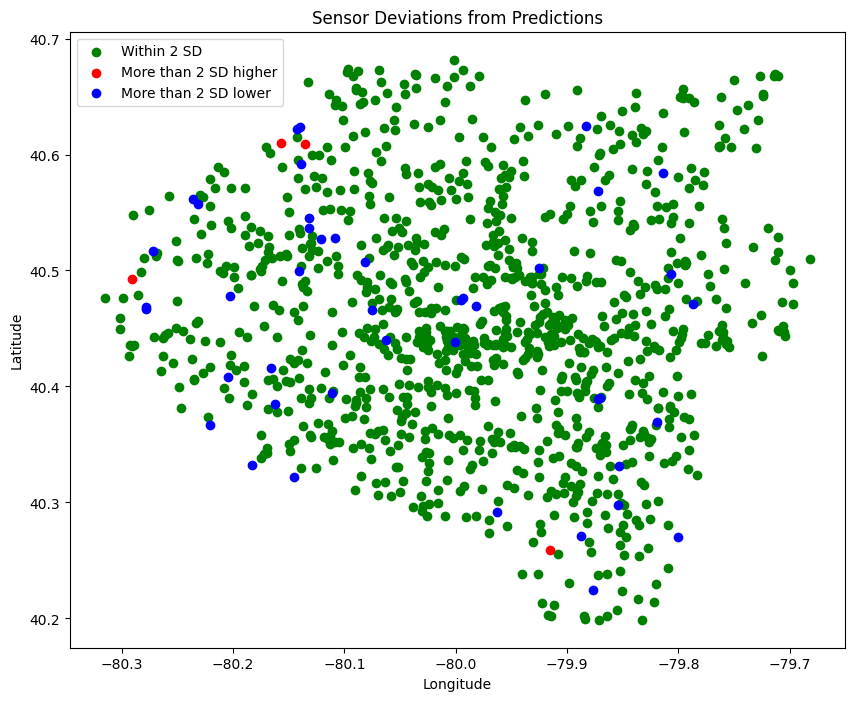

Percentage of sensors with extreme deviations: 4.2152466367713


In [36]:
plt.figure(figsize=(10, 8))
for label, color in zip(['Within 2 SD', 'More than 2 SD higher', 'More than 2 SD lower'], ['green', 'red', 'blue']):
    condition = {'Within 2 SD': (-2 < Data1['deviation']) & (Data1['deviation'] < 2),
                 'More than 2 SD higher': Data1['deviation'] > 2,
                 'More than 2 SD lower': Data1['deviation'] < -2}[label]
    plt.scatter(Data1.loc[condition, 'Longitude'], Data1.loc[condition, 'Latitude'], c=color, label=label)
plt.title('Sensor Deviations from Predictions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

print("Percentage of sensors with extreme deviations:", extreme_deviation_percentage)

### Question 2: Cluster-based anomaly detection (10%)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 1

B: 150 points, center (35, 5), standard deviation 5

C: 200 points, center (15, 20), standard deviation 0.1

D: 2 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point.
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


A. (1, 0) center (0, 0), standard deviation 1 Not Anomaly
$$
d = \sqrt{(1 - 0)^2 + (0 + 0)^2}=1
$$
 This point is well within the range of normal variations expected for Cluster A.

B.(35, 2)center (35, 5), standard deviation 5 Not Anomaly.
$$
d = \sqrt{(35 - 35)^2 + (2 - 5)^2}=3
$$
This point is well within the range of normal variations expected for Cluster B

C.(15, 19) center (15, 20), standard deviation 0.1,Anomaly
$$
d = \sqrt{(15 - 15)^2 + (19 - 20)^2}= 1
$$
 Not in the range of normal variations expected for Cluster C

D.(10, 11) center (10, 10), standard deviation 1,Not Anomaly
$$
d = \sqrt{(10 - 10)^2 + (11 - 10)^2}= 1
$$
The point is in the range of normal variations expected for Cluster C

### Question 3: Anomaly detection (50%)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4.

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5%)

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10%)

Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10%)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10%)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10%)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5%)

In [37]:
Data2=pd.read_csv("CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [38]:
# your code here
import pandas as pd
import numpy as np
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

In [39]:
print(Data2.columns)

Index(['County', ''\% Reporting Fair/Poor Health'',
       ''Physically Unhealthy Days Per Month'',
       ''Mentally Unhealthy Days Per Month'', ''\% Low birth weight births'',
       ''\% Smokers'', ''\% Obese'', ''Food Environment Index'',
       ''\% Physically Inactive'', ''\% With Access To Exercise'',
       ''\% Excessive Drinking'', ''\% Alcohol-Impaired Driving Deaths'',
       ''Chlamydia Rate'', ''Teen Birth Rate'', ''\% Uninsured'',
       ''Preventable Hosp. Rate'', ''\% Dibetics receiving HbA1c'',
       ''\% Mammography'', ''Graduation Rate'', ''\% Some College'',
       ''\% Unemployed'', ''\% Children in Poverty'', ''80/20 Income Ratio'',
       ''\% Single-Parent Households'', ''Association Rate'',
       ''Violent Crime Rate'', ''Injury Death Rate'', ''Average Daily PM2.5'',
       ''\% Severe Housing Problems'', ''\% Drive Alone'',
       ''\% Long Commute - Drives Alone''],
      dtype='object')


In [40]:


selected_cols = Data2[['County', ''\% Smokers'', ''\% Obese'',  ''Violent Crime Rate'',
       ''80/20 Income Ratio'',''\% Children in Poverty'',''Average Daily PM2.5']]
Data2 = Data2[selected_cols]
Data2.dropna(inplace=True)
cols_to_discretize = ["'% Smokers'", "'% Obese'", "'Violent Crime Rate'",
                      "'80/20 Income Ratio'", "'% Children in Poverty'", "'Average Daily PM2.5'"]
for col in cols_to_discretize:
    Data2[col] = pd.cut(Data2[col], bins=5, labels=[0, 1, 2, 3, 4]).astype(int)
Data2

KeyError: "None of [Index(['county', 'smokers', 'obese', 'violent_crime_rate',\n       '80/20_income_ratio', 'children_poverty', 'avg_pm2.5'],\n      dtype='object')] are in the [columns]"